In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import os
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import inception_v3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

training_data_path = pathlib.Path("/content/drive/MyDrive/DL_A2_transfer_learning/Dataset/train")

testing_data_path = pathlib.Path("/content/drive/MyDrive/DL_A2_transfer_learning/Dataset/test")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][100:106]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(1, 6, idx+1)
        img = plt.imread(img_path)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(img, cmap='gray')

In [ ]:
img_height = 224
img_width = 224
batch_size = 100

# Set validation_split to 0.2 (1/5th of the data)
training_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
                                                                    shear_range=0.2,
                                                                    zoom_range=0.2,
                                                                    horizontal_flip=True,
                                                                    vertical_flip=True,
                                                                    rescale=1/255.0,
                                                                    validation_split=0.2)  # 20% for validation

# Training generator with subset='training' (80% of data)
train_generator = training_data_gen.flow_from_directory(training_data_path,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        class_mode='categorical',
                                                        subset='training')  # Use training subset (80%)

# Validation generator with subset='validation' (20% of data)
validation_generator = training_data_gen.flow_from_directory(training_data_path,  # Using training data path
                                                             target_size=(img_height, img_width),
                                                             batch_size=batch_size,
                                                             shuffle=True,
                                                             class_mode='categorical',
                                                             subset='validation')  # Use validation subset (20%)

# Testing data generator remains unchanged
testing_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

test_generator = testing_data_gen.flow_from_directory(testing_data_path,
                                                      target_size=(img_height, img_width),
                                                      batch_size=batch_size,
                                                      seed=0,
                                                      shuffle=False,
                                                      class_mode='categorical')

Found 2800 images belonging to 5 classes.
Found 700 images belonging to 5 classes.
Found 700 images belonging to 5 classes.


In [ ]:
Image(url='https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/Screenshot-from-2018-10-17-11-14-10.png',
      width=750,
      height=500)

In [ ]:
Image(url='https://miro.medium.com/max/2434/1*_rCyzi7fQzc_Q1gCqSLM1g.png',
      width=750,
      height=500)

In [ ]:
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False,
                                     input_shape=(224, 224, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
inc_model = tf.keras.models.Sequential()

inc_model .add(base_model)

inc_model.add(tf.keras.layers.Flatten())
inc_model.add(tf.keras.layers.Dense(256, activation='relu'))
inc_model.add(tf.keras.layers.BatchNormalization())
inc_model.add(tf.keras.layers.Dropout(0.4))

inc_model.add(tf.keras.layers.Dense(128, activation='relu'))
inc_model.add(tf.keras.layers.BatchNormalization())
inc_model.add(tf.keras.layers.Dropout(0.4))


inc_model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [ ]:
inc_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_95               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,945,317 (133.31 MB)

 Trainable params: 13,141,765 (50.13 MB)

 Non-trainable params: 21,803,552 (83.17 MB)

In [ ]:
inc_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
history = inc_model.fit(train_generator, steps_per_epoch=(len(train_generator)),
validation_data= validation_generator, validation_steps=(len(validation_generator)),
              epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1832s 65s/step - acc: 0.8059 - loss: 0.5981 - val_acc: 0.9571 - val_loss: 0.1870
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - acc: 0.9401 - loss: 0.1852 - val_acc: 0.9443 - val_loss: 0.2491
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - acc: 0.9500 - loss: 0.1526 - val_acc: 0.9671 - val_loss: 0.1254
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.9530 - loss: 0.1265 - val_acc: 0.9557 - val_loss: 0.1556
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - acc: 0.9653 - loss: 0.1062 - val_acc: 0.9629 - val_loss: 0.1119
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - acc: 0.9500 - loss: 0.1518 - val_acc: 0.9586 - val_loss: 0.1252
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.9671 - loss: 0.1087 - val_acc: 0.9529 - val_loss: 0.1329
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - acc: 0.9686 - loss: 0.0962 - val_acc: 0.9729 - val_loss: 0.0968
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - acc: 0.9655 - lo

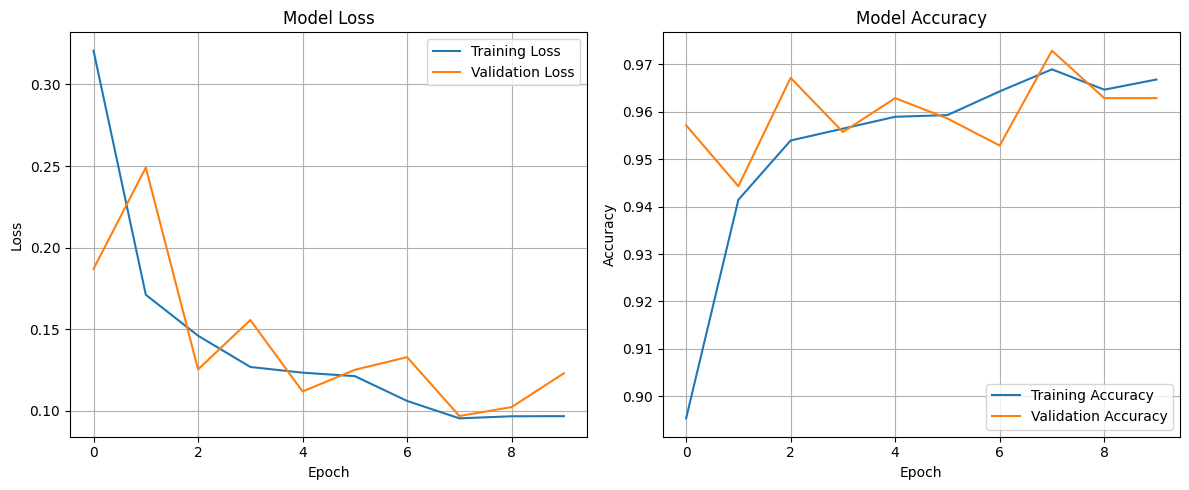

In [ ]:
# Plot training & validation loss and accuracy values
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')  # Change 'accuracy' to 'acc'
plt.plot(history.history['val_acc'], label='Validation Accuracy')  # Change 'val_accuracy' to 'val_acc'
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
inc_model.evaluate(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 319s 53s/step - acc: 0.9636 - loss: 0.0917


[0.07899164408445358, 0.9728571176528931]

In [ ]:
base_model.trainable = True

se_trainable = False

for layer in base_model.layers:
    if layer.name == "conv2d_945":
        set_trainable = True
    if se_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
inc_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
                  metrics=['acc'])

In [ ]:
history = inc_model.fit(train_generator, steps_per_epoch=(len(train_generator)),
validation_data= validation_generator, validation_steps=(len(validation_generator)),
              epochs=10)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - acc: 0.9657 - loss: 0.0974 - val_acc: 0.9671 - val_loss: 0.1059
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - acc: 0.9738 - loss: 0.0863 - val_acc: 0.9671 - val_loss: 0.1000
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - acc: 0.9719 - loss: 0.0801 - val_acc: 0.9643 - val_loss: 0.1095
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - acc: 0.9720 - loss: 0.0917 - val_acc: 0.9700 - val_loss: 0.1018
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - acc: 0.9657 - loss: 0.0965 - val_acc: 0.9614 - val_loss: 0.1057
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - acc: 0.9679 - loss: 0.0944 - val_acc: 0.9671 - val_loss: 0.0889
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - acc: 0.9670 - loss: 0.0925 - val_acc: 0.9686 - val_loss: 0.0973
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.9701 - loss: 0.0795 - val_acc: 0.9714 - val_loss: 0.0847
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - acc: 0.9669 - loss: 

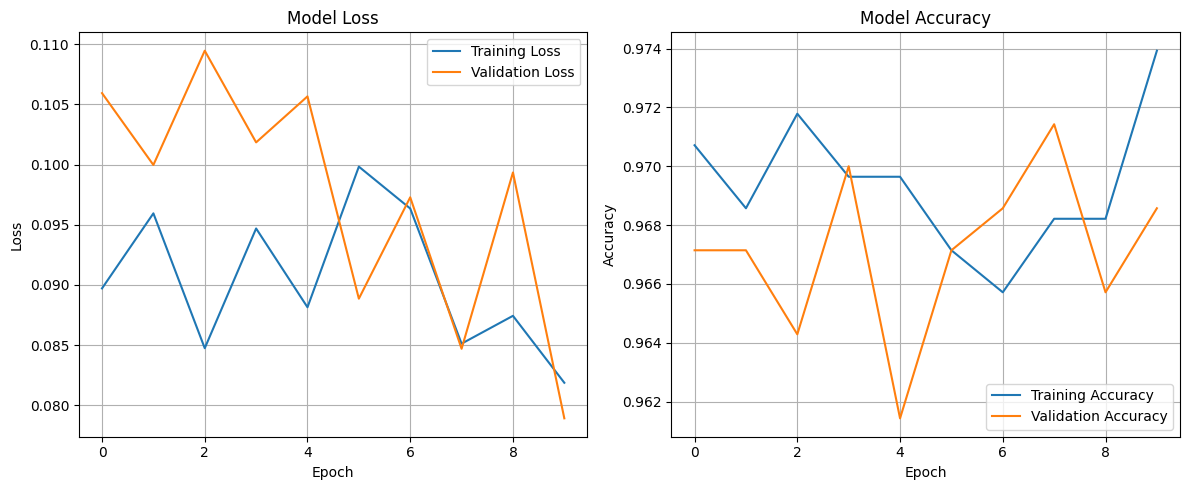

In [ ]:
# Plot training & validation loss and accuracy values
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')  # Change 'accuracy' to 'acc'
plt.plot(history.history['val_acc'], label='Validation Accuracy')  # Change 'val_accuracy' to 'val_acc'
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
inc_model.evaluate(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 506ms/step - acc: 0.9743 - loss: 0.0675


[0.0642252117395401, 0.977142870426178]

In [ ]:
from tensorflow.keras.optimizers import Adam

# Create an Adam optimizer instance
optimizer = Adam()

# Print the optimizer's configuration
print(optimizer.get_config())

{'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
